# MonsoonBench: Complete Package Walkthrough

This notebook demonstrates all the functionality of the MonsoonBench package, including:
1. **Data Loading** - Using the registry system to load data
2. **Configuration** - Loading configuration from files
3. **Metrics Computation** - All three model types (Climatology, Deterministic, Probabilistic)
4. **Visualization** - Spatial plots and comparisons
5. **Data Export** - Downloading metrics in multiple formats

**Version:** 0.1.0  
**Author:** MonsoonBench Contributors

## 1. Setup and Imports

In [1]:
# Core imports from monsoonbench
from pathlib import Path

import geopandas as gpd

# Standard scientific libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import monsoonbench
from monsoonbench import (
    ClimatologyOnsetMetrics,
    DeterministicOnsetMetrics,
    ProbabilisticOnsetMetrics,
    get_registered,  # See registered loaders
    plot_spatial_metrics,
)
from monsoonbench.visualization import (
    compare_models,
    download_spatial_metrics_data,
)

# Create output directory
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)

print(f"MonsoonBench version: {monsoonbench.__version__}")
print(f"Available functions: {monsoonbench.__all__}")

MonsoonBench version: 0.1.0
Available functions: ['__version__', 'main', 'load', 'get_registered', 'register_loader', 'DeterministicOnsetMetrics', 'ProbabilisticOnsetMetrics', 'ClimatologyOnsetMetrics', 'load_config', 'plot_spatial_metrics']


## 2. Configuration

MonsoonBench supports both programmatic configuration and YAML config files.

### Option 1: Programmatic Configuration

In [2]:
# Manual configuration - adjust these paths to your data locations
config = {
    "years": [2019, 2020, 2021],  # Years to evaluate
    "imd_folder": "../../../data/imd_rainfall_data/2p0",  # Ground truth rainfall
    "thres_file": "../../../data/imd_onset_threshold/mwset2x2.nc4",  # Onset threshold
    "shpfile_path": "../../../data/ind_map_shpfile/india_shapefile.shp",  # India shapefile
    "deterministic_forecast_dir": "../../../data/model_forecast_data/aifs/daily_0z/tp_2p0_lsm/",
    "probabilistic_forecast_dir": "../../../data/model_forecast_data/IFS-S2S/tp_2p0",
    # Evaluation parameters
    "tolerance_days": 3,  # Days tolerance for "correct" prediction
    "verification_window": 1,  # Days after init to start validation
    "forecast_days": 15,  # Length of forecast window
    "max_forecast_day": 15,  # Max day to consider for onset
    "mok": True,  # Use MOK date filter (June 2nd)
    "mok_month": 6,
    "mok_day": 2,
    "onset_window": 5,  # Onset detection window
}

print("Configuration loaded:")
print(f"  Years: {config['years']}")
print(f"  Tolerance: {config['tolerance_days']} days")
print(f"  MOK filter: {config['mok']} ({config['mok_month']}/{config['mok_day']})")

Configuration loaded:
  Years: [2019, 2020, 2021]
  Tolerance: 3 days
  MOK filter: True (6/2)


### Option 2: YAML Configuration File

You can also use a YAML config file (see `examples/config.yaml` for template):

```python
# Load from YAML
config = load_config('path/to/config.yaml')
```

## 3. Data Loading

MonsoonBench includes a data loader registry system. Let's see what loaders are available:

In [3]:
# Check registered data loaders
registered_loaders = get_registered()
print("Registered data loaders:")
for name, loader_class in registered_loaders.items():
    print(f"  - {name}: {loader_class.__name__}")

Registered data loaders:
  - imd_rain: IMDRainLoader


### Load IMD Rainfall Data

The data loader handles dimension renaming, chunking, and standardization automatically:

In [4]:
# Example: Load IMD rainfall data for a single year
# Note: The metrics classes handle data loading internally,
# but you can also load data directly for exploration

# Uncomment to load data manually:
# imd_data = load(
#     name="imd_rain",
#     root=config["imd_folder"],
#     years=2021,
#     chunks={"time": 64},
#     to_dataarray=True
# )
# print(imd_data)

print("Data loading capability demonstrated.")
print("Metrics classes will load data automatically when needed.")

Data loading capability demonstrated.
Metrics classes will load data automatically when needed.


## 4. Climatology Baseline Metrics

The climatology baseline uses historical average onset dates as a "forecast".
This provides a simple benchmark to compare model performance against.

In [5]:
print("=" * 60)
print("CLIMATOLOGY BASELINE METRICS")
print("=" * 60)

# Compute climatology baseline
climatology_df, climatological_onset_doy = (
    ClimatologyOnsetMetrics.compute_climatology_baseline_multiple_years(
        years=config["years"],
        imd_folder=config["imd_folder"],
        thres_file=config["thres_file"],
        tolerance_days=config["tolerance_days"],
        verification_window=config["verification_window"],
        forecast_days=config["forecast_days"],
        max_forecast_day=config["max_forecast_day"],
        mok=config["mok"],
        onset_window=config["onset_window"],
        mok_month=config["mok_month"],
        mok_day=config["mok_day"],
    )
)

# Create onset dict for spatial metrics
onset_da_dict_clim = dict.fromkeys(config["years"], climatological_onset_doy)

# Create spatial metrics
climatology_metrics = ClimatologyOnsetMetrics.create_spatial_far_mr_mae(
    climatology_df, onset_da_dict_clim
)

print("\nClimatology metrics computed!")
print(f"Available metrics: {list(climatology_metrics.keys())}")

CLIMATOLOGY BASELINE METRICS
Computing climatological onset reference...
Computing climatological onset from 124 years: 1901-2024
Loading IMD rainfall from: ../../../data/imd_rainfall_data/2p0/data_1901.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1901-06-02) as start date for onset detection
Loading IMD rainfall from: ../../../data/imd_rainfall_data/2p0/data_1902.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1902-06-02) as start date for onset detection
Loading IMD rainfall from: ../../../data/imd_rainfall_data/2p0/data_1903.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1903-06-02) as start date for onset detection
Loading IMD rainfall from: ../../../data/imd_rainfall_data/2p0/data_1904.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (1904-06-02) as s

### Visualize Climatology Results

Detected resolution: 2.0 degrees
Using 2.0-degree CMZ polygon coordinates
Figure saved to: outputs/climatology_metrics.png

=== CORE MONSOON ZONE (CMZ) AVERAGES ===
CMZ Mean MAE (avg across years): 6.85 ± 0.88 days
CMZ False Alarm Rate: 20.0 %
CMZ Miss Rate: 50.2 %


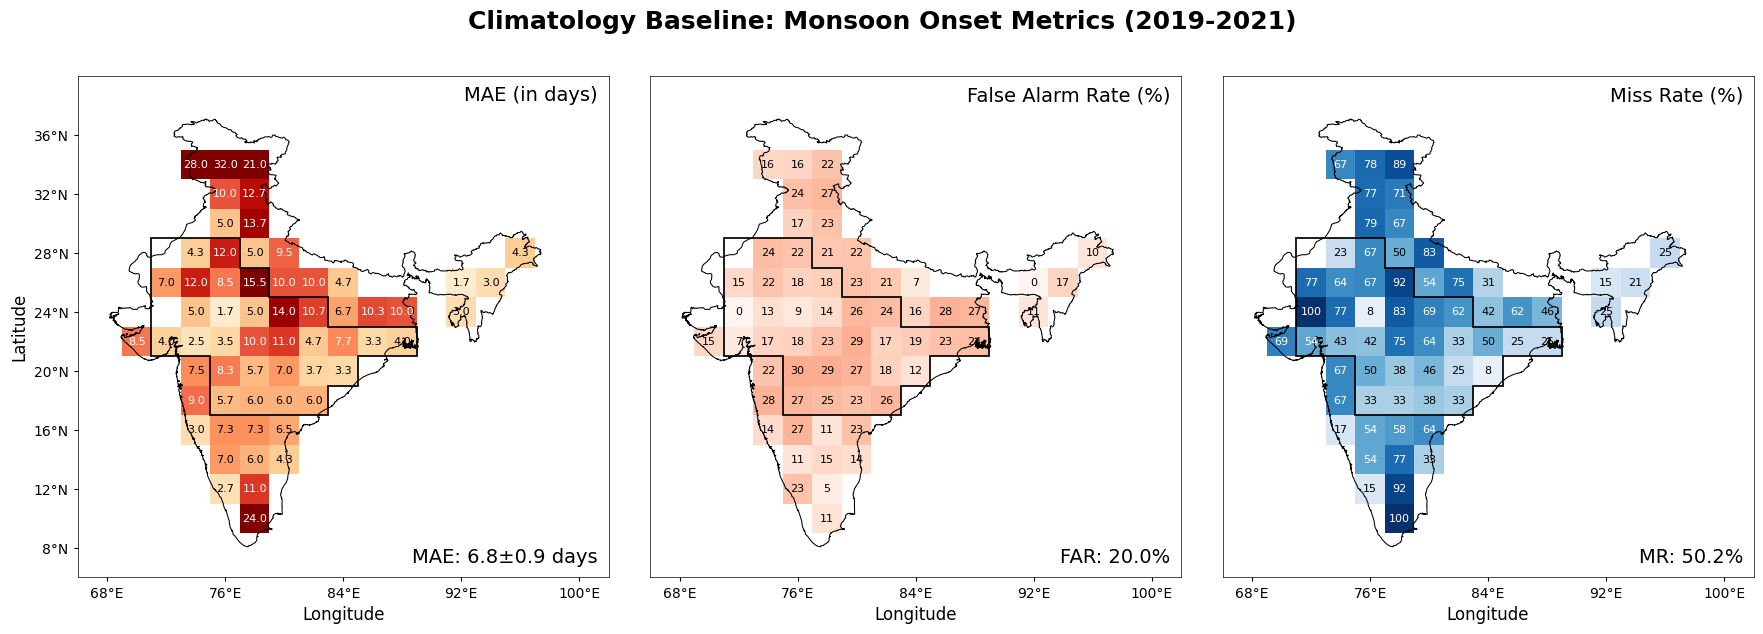


Climatology Summary Statistics:
  Mean FAR: 0.188
  Mean Miss Rate: 0.537
  Mean MAE: 8.24 days


In [6]:
# Plot spatial metrics for climatology
fig, axes = plot_spatial_metrics(
    climatology_metrics,
    config["shpfile_path"],
    figsize=(18, 6),
    save_path=output_dir / "climatology_metrics.png",
)

fig.suptitle(
    f"Climatology Baseline: Monsoon Onset Metrics ({min(config['years'])}-{max(config['years'])})",
    fontsize=18,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nClimatology Summary Statistics:")
print(f"  Mean FAR: {float(climatology_metrics['false_alarm_rate'].mean()):.3f}")
print(f"  Mean Miss Rate: {float(climatology_metrics['miss_rate'].mean()):.3f}")
print(f"  Mean MAE: {float(climatology_metrics['mean_mae'].mean()):.2f} days")

## 5. Deterministic Model Metrics

Deterministic models provide a single forecast. Here we evaluate a deterministic onset prediction model.

In [7]:
print("=" * 60)
print("DETERMINISTIC MODEL METRICS")
print("=" * 60)

# Compute deterministic metrics
deterministic_df, deterministic_onset_dict = (
    DeterministicOnsetMetrics.compute_metrics_multiple_years(
        years=config["years"],
        imd_folder=config["imd_folder"],
        thres_file=config["thres_file"],
        model_forecast_dir=config["deterministic_forecast_dir"],
        tolerance_days=config["tolerance_days"],
        verification_window=config["verification_window"],
        forecast_days=config["forecast_days"],
        max_forecast_day=config["max_forecast_day"],
        mok=config["mok"],
        onset_window=config["onset_window"],
        mok_month=config["mok_month"],
        mok_day=config["mok_day"],
    )
)

# Create spatial metrics
deterministic_metrics = DeterministicOnsetMetrics.create_spatial_far_mr_mae(
    deterministic_df, deterministic_onset_dict
)

print("\nDeterministic metrics computed!")
print(f"Years processed: {list(deterministic_onset_dict.keys())}")

DETERMINISTIC MODEL METRICS

Processing year 2019
Loading IMD rainfall from: ../../../data/imd_rainfall_data/2p0/data_2019.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (2019-06-02) as start date for onset detection
Processing 26 init times x 16 lats x 17 lons...
Using MOK (6/2 filter) for onset detection
Only processing forecasts initialized before observed onset dates
Processing init time 1/26: 2019-05-02
Processing init time 6/26: 2019-05-20
Processing init time 11/26: 2019-06-06
Processing init time 16/26: 2019-06-24
Processing init time 21/26: 2019-07-11
Processing init time 26/26: 2019-07-29

Processing Summary:
Total potential initializations: 7072
Skipped (no observed onset): 5460
Skipped (initialized after observed onset): 688
Valid initializations processed: 924
Onsets found: 307
Onset rate: 0.332
Computing onset metrics with tolerance = 3 days
Verification window starts 1 days after initialization
Forecast window len

### Visualize Deterministic Results

Detected resolution: 2.0 degrees
Using 2.0-degree CMZ polygon coordinates
Figure saved to: outputs/deterministic_metrics.png

=== CORE MONSOON ZONE (CMZ) AVERAGES ===
CMZ Mean MAE (avg across years): 5.00 ± 0.57 days
CMZ False Alarm Rate: 22.7 %
CMZ Miss Rate: 22.2 %


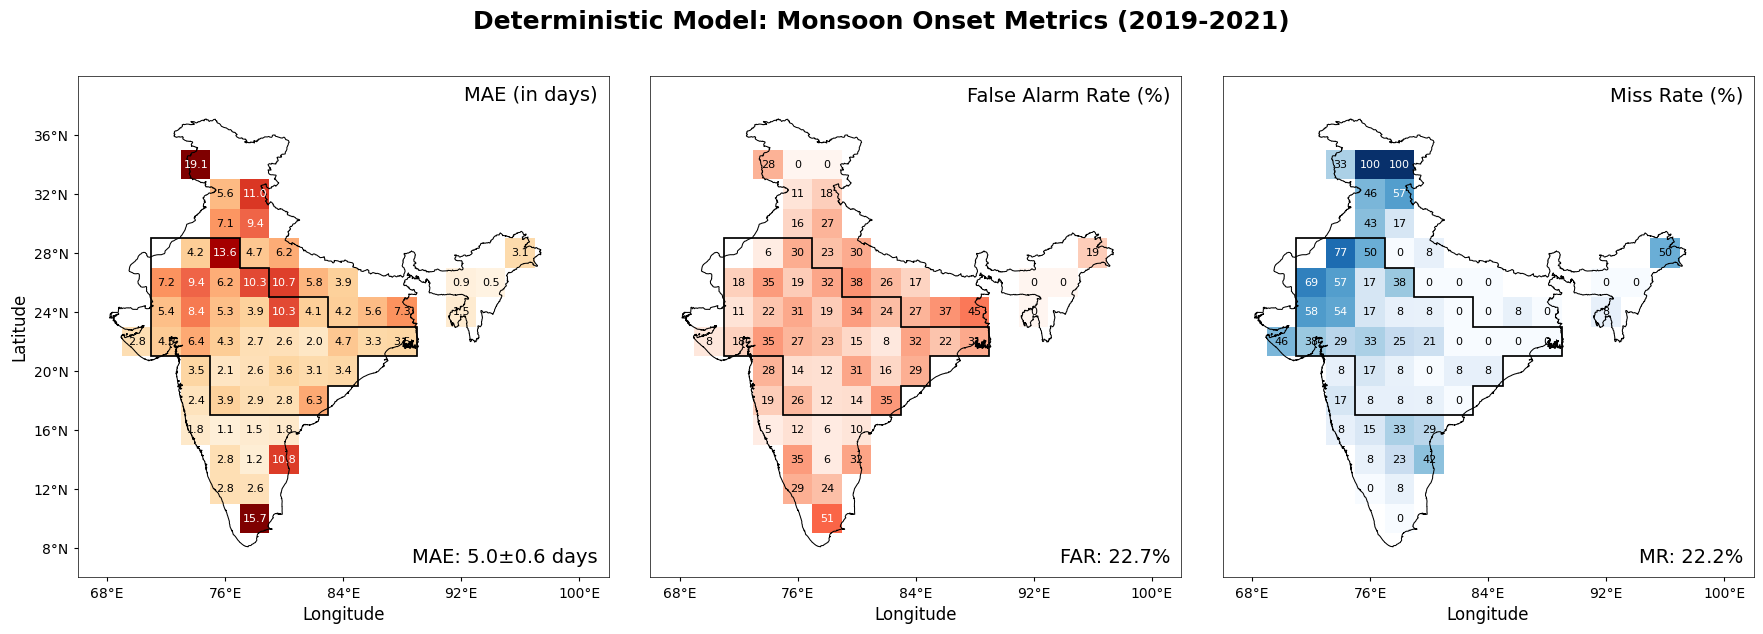


Deterministic Model Summary Statistics:
  Mean FAR: 0.211
  Mean Miss Rate: 0.221
  Mean MAE: 5.18 days


In [8]:
# Plot spatial metrics for deterministic model
fig, axes = plot_spatial_metrics(
    deterministic_metrics,
    config["shpfile_path"],
    figsize=(18, 6),
    save_path=output_dir / "deterministic_metrics.png",
)

fig.suptitle(
    f"Deterministic Model: Monsoon Onset Metrics ({min(config['years'])}-{max(config['years'])})",
    fontsize=18,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDeterministic Model Summary Statistics:")
print(f"  Mean FAR: {float(deterministic_metrics['false_alarm_rate'].mean()):.3f}")
print(f"  Mean Miss Rate: {float(deterministic_metrics['miss_rate'].mean()):.3f}")
print(f"  Mean MAE: {float(deterministic_metrics['mean_mae'].mean()):.2f} days")

## 6. Probabilistic Model Metrics

Probabilistic models provide ensemble forecasts. Here we evaluate a probabilistic onset prediction model.

In [9]:
print("=" * 60)
print("PROBABILISTIC MODEL METRICS")
print("=" * 60)

# Compute probabilistic metrics
probabilistic_df, probabilistic_onset_dict = (
    ProbabilisticOnsetMetrics.compute_metrics_multiple_years(
        years=config["years"],
        imd_folder=config["imd_folder"],
        thres_file=config["thres_file"],
        model_forecast_dir=config["probabilistic_forecast_dir"],
        tolerance_days=config["tolerance_days"],
        verification_window=config["verification_window"],
        forecast_days=config["forecast_days"],
        max_forecast_day=config["max_forecast_day"],
        mok=config["mok"],
        onset_window=config["onset_window"],
        mok_month=config["mok_month"],
        mok_day=config["mok_day"],
    )
)

# Create spatial metrics
probabilistic_metrics = ProbabilisticOnsetMetrics.create_spatial_far_mr_mae(
    probabilistic_df, probabilistic_onset_dict
)

print("\nProbabilistic metrics computed!")
print(f"Years processed: {list(probabilistic_onset_dict.keys())}")

PROBABILISTIC MODEL METRICS

Processing year 2019
Loading IMD rainfall from: ../../../data/imd_rainfall_data/2p0/data_2019.nc
Renamed dimensions: {'latitude': 'lat', 'longitude': 'lon', 'TIME': 'time'}
Using MOK date (June 2nd) (2019-06-02) as start date for onset detection
Processing 26 init times x 16 lats x 17 lons...
Using MOK (6/2 filter) for onset detection
Only processing forecasts initialized before observed onset dates
Requiring ≥50% of 11 members to have onset for ensemble onset
Processing init time 1/26: 2019-05-02
Processing init time 6/26: 2019-05-20
Processing init time 11/26: 2019-06-06
Processing init time 16/26: 2019-06-24
Processing init time 21/26: 2019-07-11
Processing init time 26/26: 2019-07-29

Processing Summary:
Total potential initializations: 7072
Skipped (no observed onset): 5460
Skipped (initialized after observed onset): 688
Valid initializations processed: 924
Ensemble onsets found (≥50% members): 273
Ensemble onset rate: 0.295
Note: Only onsets on or aft

### Visualize Probabilistic Results

Detected resolution: 2.0 degrees
Using 2.0-degree CMZ polygon coordinates
Figure saved to: outputs/probabilistic_metrics.png

=== CORE MONSOON ZONE (CMZ) AVERAGES ===
CMZ Mean MAE (avg across years): 4.47 ± 0.15 days
CMZ False Alarm Rate: 17.7 %
CMZ Miss Rate: 24.2 %


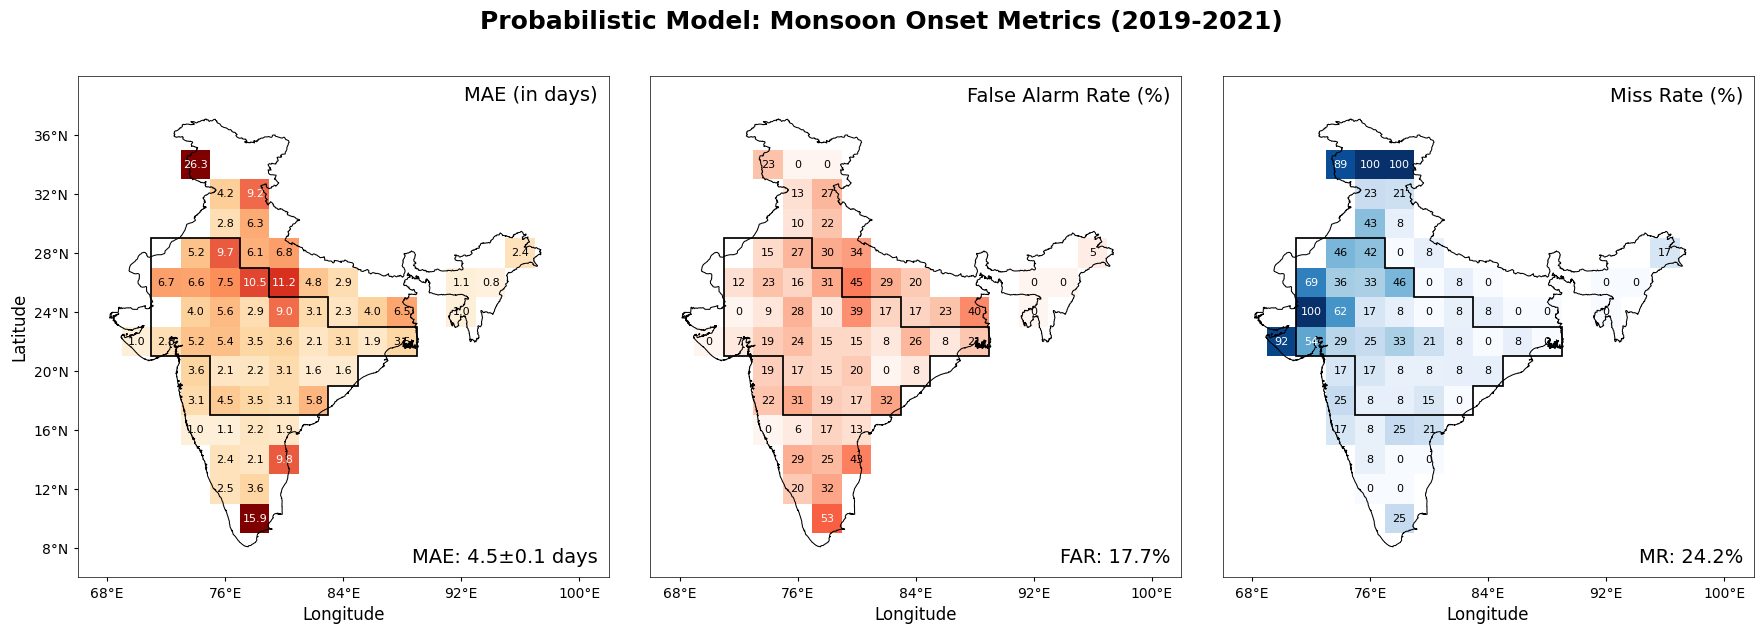


Probabilistic Model Summary Statistics:
  Mean FAR: 0.185
  Mean Miss Rate: 0.224
  Mean MAE: 4.71 days


In [10]:
# Plot spatial metrics for probabilistic model
fig, axes = plot_spatial_metrics(
    probabilistic_metrics,
    config["shpfile_path"],
    figsize=(18, 6),
    save_path=output_dir / "probabilistic_metrics.png",
)

fig.suptitle(
    f"Probabilistic Model: Monsoon Onset Metrics ({min(config['years'])}-{max(config['years'])})",
    fontsize=18,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nProbabilistic Model Summary Statistics:")
print(f"  Mean FAR: {float(probabilistic_metrics['false_alarm_rate'].mean()):.3f}")
print(f"  Mean Miss Rate: {float(probabilistic_metrics['miss_rate'].mean()):.3f}")
print(f"  Mean MAE: {float(probabilistic_metrics['mean_mae'].mean()):.2f} days")

## 7. Data Export

MonsoonBench can export metrics in multiple formats for downstream analysis and visualization.

In [12]:
# Export deterministic metrics in multiple formats
exported_paths = download_spatial_metrics_data(
    spatial_metrics=deterministic_metrics,
    output_dir=output_dir,
    filename="deterministic_spatial_metrics",
    formats=["netcdf", "csv", "json"],
    metadata={
        "model_type": "deterministic",
        "years": str(config["years"]),
        "tolerance_days": config["tolerance_days"],
        "notebook": "complete_package_walkthrough",
    },
    dropna=True,  # Remove rows with all NaN values
)

print("Exported files:")
for path in exported_paths:
    print(f"  - {path}")

Exported files:
  - outputs/deterministic_spatial_metrics.nc
  - outputs/deterministic_spatial_metrics.csv
  - outputs/deterministic_spatial_metrics.json


### Inspect Exported Data

In [13]:
# Load and display CSV export
csv_data = pd.read_csv(output_dir / "deterministic_spatial_metrics.csv")
print("CSV Export Preview:")
print(csv_data.head(10))
print(f"\nTotal grid points: {len(csv_data)}")
print(f"Columns: {list(csv_data.columns)}")

CSV Export Preview:
   lat  lon  false_alarm_rate  miss_rate   mean_mae   mae_2019  mae_2020  \
0   10   78          0.513514   0.000000  15.722222  45.166667  2.000000   
1   12   76          0.285714   0.000000   2.753968   2.333333  1.500000   
2   12   78          0.238095   0.076923   2.607143   0.250000  7.571429   
3   14   76          0.347826   0.076923   2.793651   3.666667  4.714286   
4   14   78          0.058824   0.230769   1.222222   0.666667  3.000000   
5   14   80          0.323529   0.416667  10.793651   8.333333  8.714286   
6   16   74          0.052632   0.083333   1.777778   2.500000  0.333333   
7   16   76          0.117647   0.153846   1.088889   1.666667  1.600000   
8   16   78          0.058824   0.333333   1.500000   2.000000  2.500000   
9   16   80          0.095238   0.285714   1.750000   3.000000  2.250000   

    mae_2021  
0   0.000000  
1   4.428571  
2   0.000000  
3   0.000000  
4   0.000000  
5  15.333333  
6   2.500000  
7   0.000000  
8   0.00

In [14]:
# Load and display NetCDF export
nc_data = xr.open_dataset(output_dir / "deterministic_spatial_metrics.nc")
print("\nNetCDF Export:")
print(nc_data)
print("\nMetadata:")
for key, value in nc_data.attrs.items():
    print(f"  {key}: {value}")


NetCDF Export:
<xarray.Dataset> Size: 13kB
Dimensions:           (lat: 16, lon: 17)
Coordinates:
  * lat               (lat) int64 128B 8 10 12 14 16 18 20 ... 28 30 32 34 36 38
  * lon               (lon) int64 136B 68 70 72 74 76 78 ... 90 92 94 96 98 100
Data variables:
    false_alarm_rate  (lat, lon) float64 2kB ...
    miss_rate         (lat, lon) float64 2kB ...
    mean_mae          (lat, lon) float64 2kB ...
    mae_2019          (lat, lon) float64 2kB ...
    mae_2020          (lat, lon) float64 2kB ...
    mae_2021          (lat, lon) float64 2kB ...
Attributes:
    generated_at:    2025-12-01T21:31:44Z
    generated_by:    monsoonbench.visualization.data_downloader
    variables:       ['false_alarm_rate', 'mae_2019', 'mae_2020', 'mae_2021',...
    lat_range:       [ 8. 38.]
    lon_range:       [ 68. 100.]
    lat_resolution:  2.0
    lon_resolution:  2.0
    model_type:      deterministic
    years:           [2019, 2020, 2021]
    tolerance_days:  3
    notebook:       

## 8. Model Comparison

Compare all three approaches side-by-side to understand relative performance.

Model Comparison Summary:
                         cmz_mae_mean_days  cmz_mae_se_days  cmz_far_pct  \
model                                                                      
Climatology                       6.847104         0.884399    19.978228   
Deterministic (AIFS)              4.996454         0.567900    22.710683   
Probabilistic (IFS-S2S)           4.469061         0.148196    17.668443   

                         cmz_mr_pct  overall_mae_mean_days  overall_far_pct  \
model                                                                         
Climatology               50.222833               7.876662        18.767144   
Deterministic (AIFS)      22.182540               5.124538        21.091136   
Probabilistic (IFS-S2S)   24.203297               4.628318        18.466942   

                         overall_mr_pct  
model                                    
Climatology                   53.713222  
Deterministic (AIFS)          22.143448  
Probabilistic (IFS-S2S)      

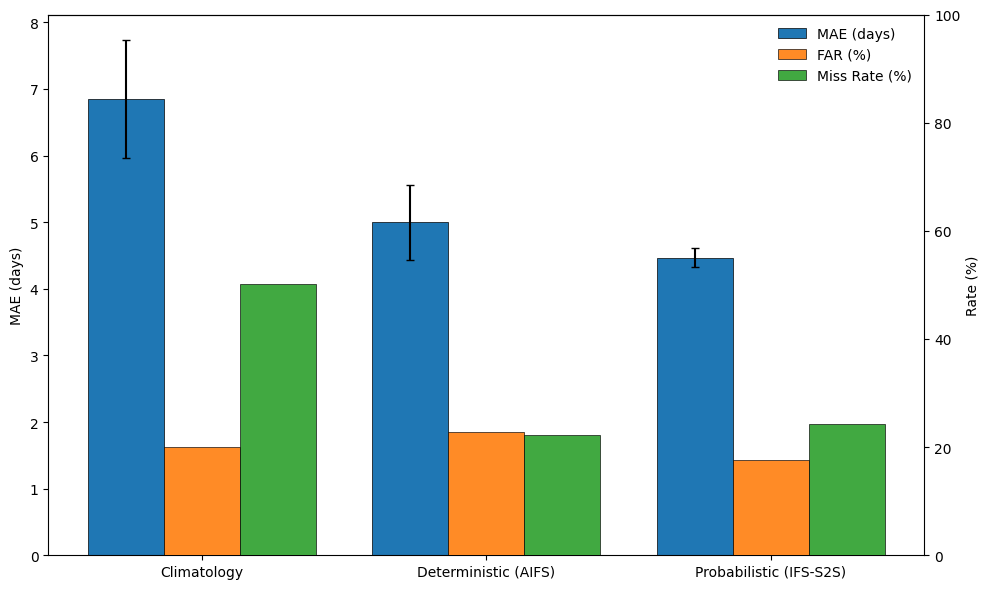

In [16]:
# Create comparison table using the compare_models function
model_comparison = {
    "Climatology": climatology_metrics,
    "Deterministic (AIFS)": deterministic_metrics,
    "Probabilistic (IFS-S2S)": probabilistic_metrics,
}

comparison_df, comp_fig, comp_axes = compare_models(model_comparison)

print("Model Comparison Summary:")
print(comparison_df)
plt.show()

### Comprehensive Side-by-Side Comparison

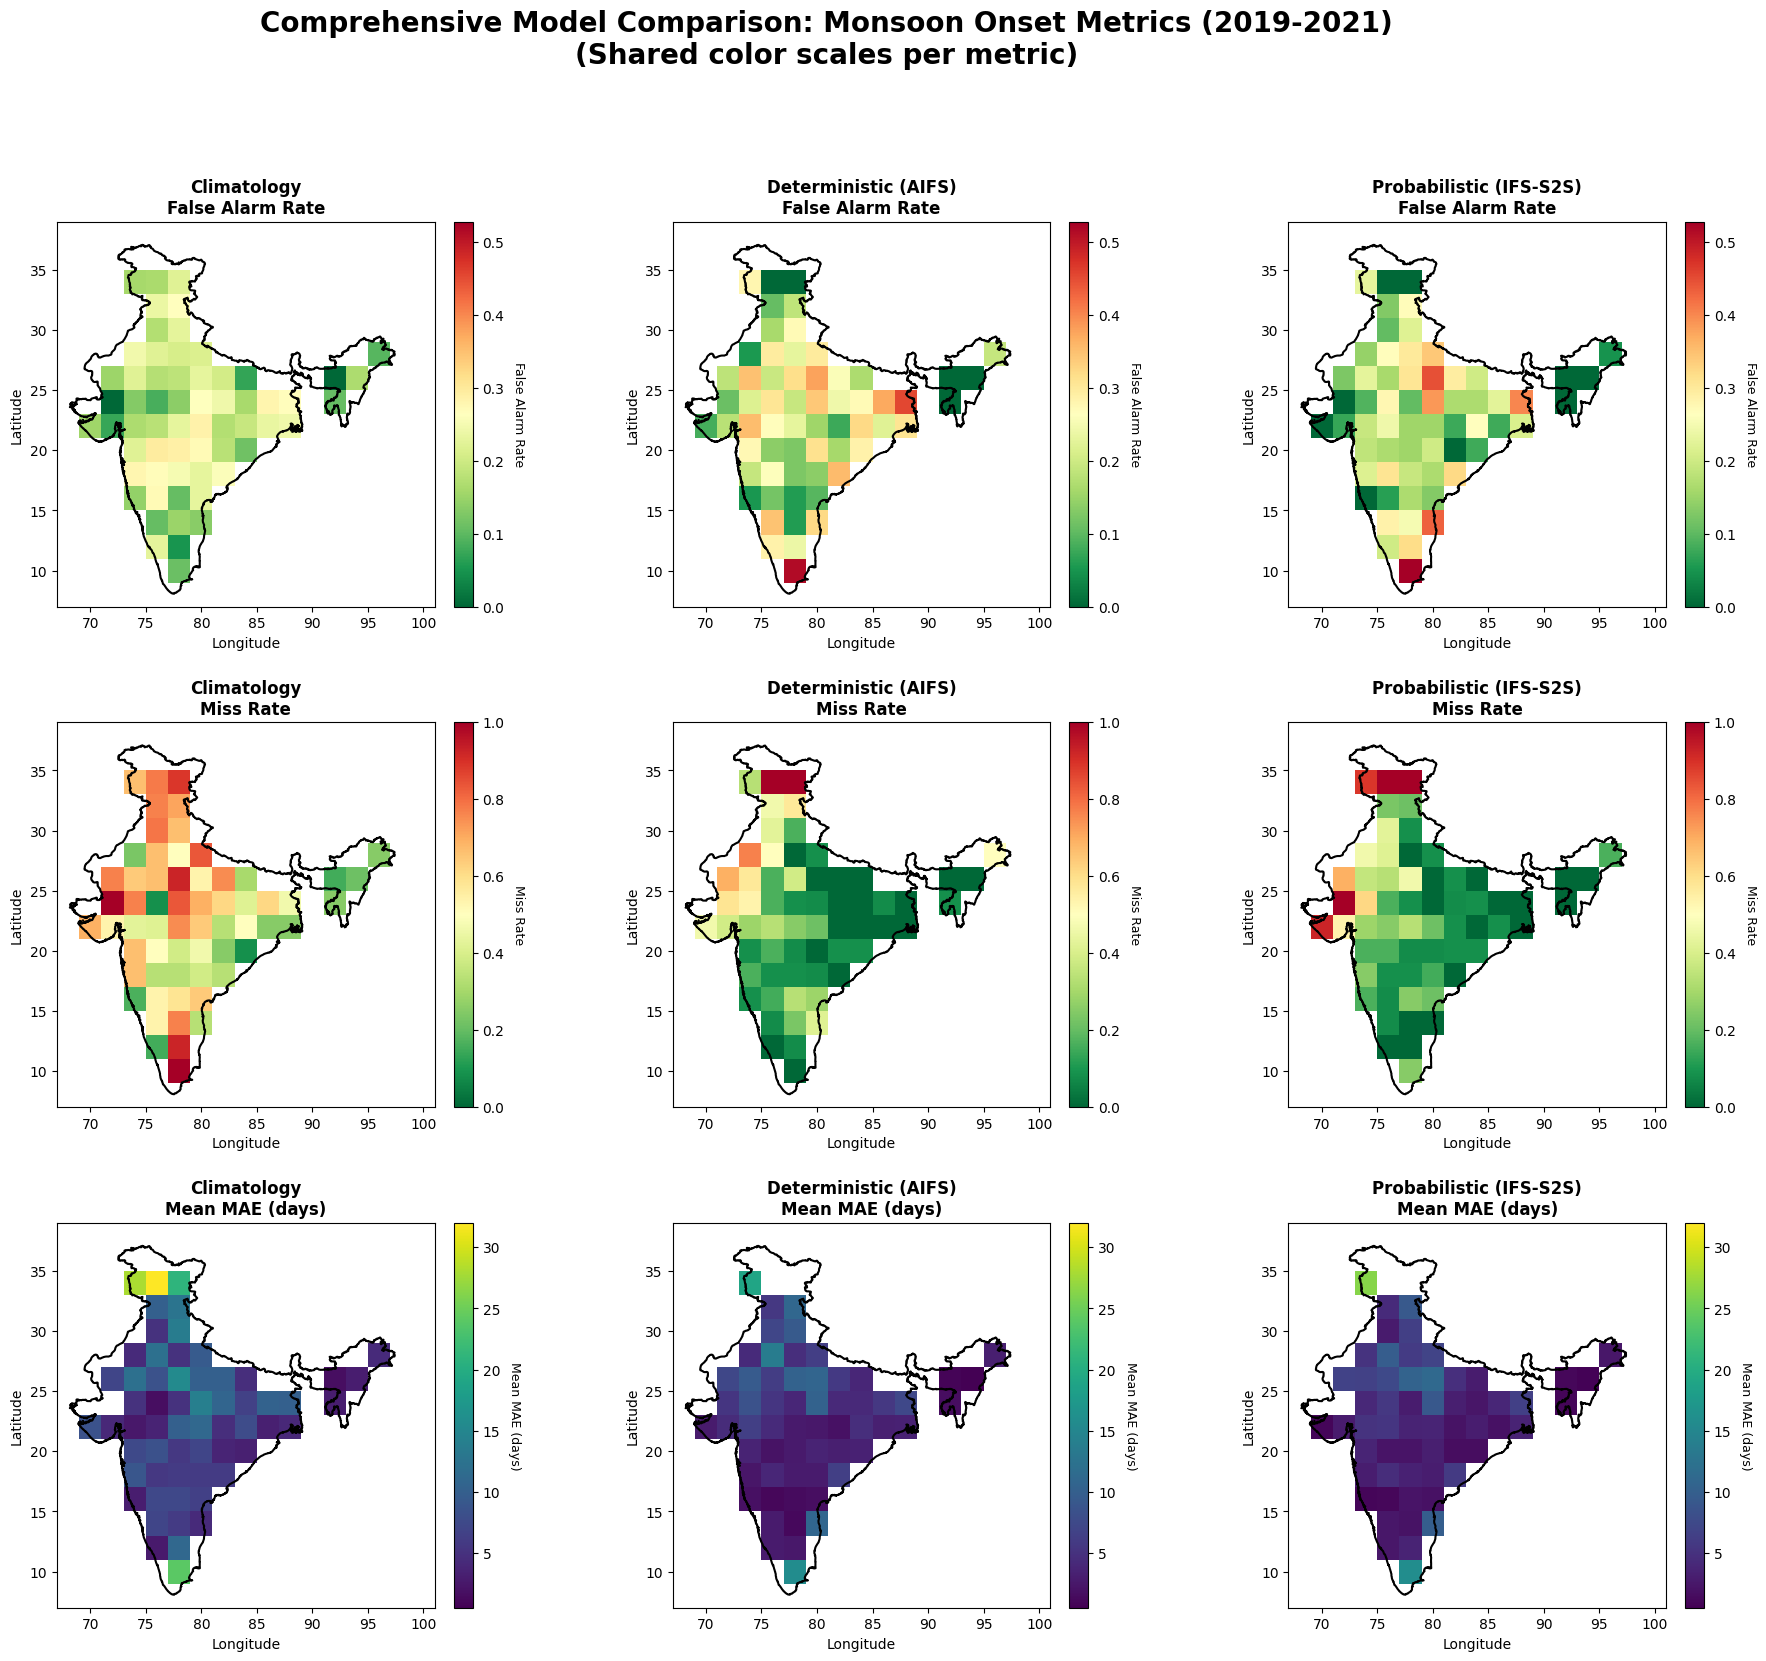


DETAILED COMPARISON STATISTICS

Climatology:
  FAR:        0.188 (mean) ± 0.071 (std)
  Miss Rate:  0.537 (mean) ± 0.237 (std)
  Mean MAE:   8.24 days (mean) ± 5.86 (std)

Deterministic (AIFS):
  FAR:        0.211 (mean) ± 0.117 (std)
  Miss Rate:  0.221 (mean) ± 0.248 (std)
  Mean MAE:   5.18 days (mean) ± 3.71 (std)

Probabilistic (IFS-S2S):
  FAR:        0.185 (mean) ± 0.123 (std)
  Miss Rate:  0.224 (mean) ± 0.272 (std)
  Mean MAE:   4.71 days (mean) ± 4.11 (std)


In [17]:
# Create a comprehensive comparison plot
fig = plt.figure(figsize=(22, 18))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

models = ["Climatology", "Deterministic (AIFS)", "Probabilistic (IFS-S2S)"]
metrics_data = [climatology_metrics, deterministic_metrics, probabilistic_metrics]
metric_names = ["False Alarm Rate", "Miss Rate", "Mean MAE (days)"]
metric_keys = ["false_alarm_rate", "miss_rate", "mean_mae"]

# Load India shapefile for overlay
india_shp = gpd.read_file(config["shpfile_path"])

# Calculate shared color scales for each metric
shared_ranges = {}
for metric_key in metric_keys:
    all_values = []
    for data in metrics_data:
        values = data[metric_key].values
        all_values.append(values[~np.isnan(values)])
    all_values = np.concatenate(all_values)
    shared_ranges[metric_key] = (np.nanmin(all_values), np.nanmax(all_values))

# Plot each metric for all three models
for j, (metric_name, metric_key) in enumerate(zip(metric_names, metric_keys)):
    vmin, vmax = shared_ranges[metric_key]

    for i, (model_name, data) in enumerate(zip(models, metrics_data)):
        ax = fig.add_subplot(gs[j, i])

        metric_data = data[metric_key]

        # Choose colormap based on metric type
        cmap = (
            "RdYlGn_r" if metric_key in ["false_alarm_rate", "miss_rate"] else "viridis"
        )

        im = ax.pcolormesh(
            metric_data.lon,
            metric_data.lat,
            metric_data.values,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            shading="auto",
        )

        # Overlay India boundary
        india_shp.boundary.plot(ax=ax, linewidth=1.5, edgecolor="black")

        ax.set_xlabel("Longitude", fontsize=10)
        ax.set_ylabel("Latitude", fontsize=10)
        ax.set_title(f"{model_name}\n{metric_name}", fontsize=12, fontweight="bold")

        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(metric_name, rotation=270, labelpad=15, fontsize=9)

fig.suptitle(
    f"Comprehensive Model Comparison: Monsoon Onset Metrics ({min(config['years'])}-{max(config['years'])})\n"
    "(Shared color scales per metric)",
    fontsize=20,
    fontweight="bold",
    y=0.998,
)

plt.savefig(output_dir / "comprehensive_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

# Print detailed comparison statistics
print("\n" + "=" * 80)
print("DETAILED COMPARISON STATISTICS")
print("=" * 80)

for model_name, data in zip(models, metrics_data):
    print(f"\n{model_name}:")
    print(
        f"  FAR:        {float(data['false_alarm_rate'].mean()):.3f} (mean) ± {float(data['false_alarm_rate'].std()):.3f} (std)"
    )
    print(
        f"  Miss Rate:  {float(data['miss_rate'].mean()):.3f} (mean) ± {float(data['miss_rate'].std()):.3f} (std)"
    )
    print(
        f"  Mean MAE:   {float(data['mean_mae'].mean()):.2f} days (mean) ± {float(data['mean_mae'].std()):.2f} (std)"
    )

## 9. Summary and Key Takeaways

This notebook demonstrated the complete MonsoonBench workflow:

### Features Showcased:

1. **Data Loading**
   - Registry system for pluggable loaders
   - Automatic dimension standardization
   - Chunking for large datasets

2. **Configuration**
   - Programmatic configuration
   - YAML config file support
   - Flexible parameter control

3. **Metrics Computation**
   - Climatology baseline (historical average)
   - Deterministic models (single forecast)
   - Probabilistic models (ensemble forecasts)
   - MAE, FAR, and Miss Rate calculations

4. **Visualization**
   - Spatial metric plots
   - Model comparison plots
   - India shapefile overlay
   - Customizable figure sizes and saving

5. **Data Export**
   - Multiple formats: NetCDF, CSV, Parquet, JSON
   - Metadata preservation
   - Easy integration with other tools

### Next Steps:

- Try different tolerance values
- Experiment with different forecast windows
- Add your own model forecasts
- Explore individual year metrics
- Create custom visualizations using exported data

For more examples, see:
- `package_walkthrough.ipynb` - Original walkthrough
- `compare_models.ipynb` - Advanced model comparison
- `../exploratory_notebooks/` - Additional analysis examples

## Appendix: Quick API Reference

### Data Loading
```python
from monsoonbench import load, get_registered, register_loader

# Load data
data = load(name="imd_rain", root="/path", years=[2020, 2021])

# See available loaders
loaders = get_registered()
```

### Metrics Computation
```python
from monsoonbench import DeterministicOnsetMetrics, ProbabilisticOnsetMetrics, ClimatologyOnsetMetrics

# Compute metrics (static methods)
metrics_df, onset_dict = DeterministicOnsetMetrics.compute_metrics_multiple_years(
    years=[2020], 
    model_forecast_dir="/path", 
    imd_folder="/path", 
    thres_file="/path",
    # ... other parameters
)

# Create spatial metrics
spatial_metrics = DeterministicOnsetMetrics.create_spatial_far_mr_mae(metrics_df, onset_dict)
```

### Visualization
```python
from monsoonbench import plot_spatial_metrics
from monsoonbench.visualization import compare_models, download_spatial_metrics_data

# Plot single model
fig, axes = plot_spatial_metrics(spatial_metrics, "/path/to/shapefile.shp")

# Compare models
comparison_df, fig, axes = compare_models({"Model A": metrics_a, "Model B": metrics_b})

# Export data
paths = download_spatial_metrics_data(spatial_metrics, output_dir="outputs", formats=["netcdf", "csv"])
```

### Configuration
```python
from monsoonbench import load_config

config = load_config("config.yaml")
```